Import the necessary packages:
- numpy: to operate with arrays (and compatibility with numba if needed).
- matplotlib.pyplot: to plot the diagrams
- matplotlib: to change the style of the lines for some particles.
- from scipy.special: binom, factorial, functions to calculate binomial and factorial.

In [438]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import binom, factorial

### Defining diagrams

To define diagram with n types of particle in terms of numpy arrays, we will need at least 2 arrays:

- points: contains the coordinates in the 2D plane where a "connection" can be produced. In general any type of particles could be connected to those points.
- paths: contains the ways the points are connected. For that, we indicate the position in the points array of the start and the end of the line/path. This will be the way we differentiate between the different types of particles.

**Important**: due to the implementation throughout the code to ignore 0's, it's crutial to not use (0, 0) as coordinate, and it's not recomendated to use negative values, since there are posibilities that latter functions made for simplification of the diagram produces unexpected problems.

There will be n arrays for the paths, so as a example in the case of quarks, antiquarks and gluons a diagram could be. (Note that this is not a real diagram, but defined this way to test the different functions.)

In [439]:
points =  np.array([[0, 1], [0, 3], [1, 2], [2, 2], [3, 2]])
paths_q = np.array([[1, 3], [3, 3]]) # We have introduced a counter term to test that it's representation is working
paths_a = np.array([[2, 3], [4, 5]])
paths_g = np.array([[3, 4], [3, 4]])

#### Joining paths into 1 array
But this way of separating the paths is inconvenient for the function that we define, so instead let's add them in a single array.

The function `combine_paths` accept any number of path arrays, and return an array with all the different paths of dimension (n_types, max_len, 2) with `max_len` correspondent to the length of the largest single path, and `n_types` the number of types of particles considered

In [440]:
def combine_paths(*paths):
    """ 
    Combine multiple paths into a single array with the same length by padding with zeros.
    Args:
        paths (list): list of paths to combine
    Returns:
        final_path (np.array): combined path of dimension (len(paths), max_len, 2)
    """
    max_len = max([len(path) for path in paths])
    final_path = np.zeros((len(paths), max_len, 2), dtype=int)
    for i in range(len(paths)):
        if len(paths[i]) < max_len:
            final_path[i] = np.append(paths[i], np.zeros((max_len - len(paths[i]), 2), dtype=int), axis=0)
        else:
            final_path[i] = paths[i]
    return final_path

In [441]:
paths = combine_paths(paths_q, paths_a, paths_g)

### Represent diagram

#### Additional functions

For the diagram representation due to how numpy arrays work, we will need functions that trim additional zeros for the arrays when needed, `trim_zeros_2D` and `trim_zeros_3D`.

And for detecting loops produced with a type of particle, we will use the `find_equal_subarrays` function.

In [442]:
#From Eddmik in https://stackoverflow.com/questions/34593824/trim-strip-zeros-of-a-numpy-array
#Note that for numpy 2.2 the function trim_zeros is available for ndarrays.
#I may rewirte this function as i would have done it myself, but for now we will use this one.
def trim_zeros_2D(array, axis=1):
    mask = ~(array==0).all(axis=axis)
    inv_mask = mask[::-1]
    start_idx = np.argmax(mask == True)
    end_idx = len(inv_mask) - np.argmax(inv_mask == True)
    if axis:
        return array[start_idx:end_idx,:]
    else:
        return array[:, start_idx:end_idx]
    
#From chatgpt 
def trim_zeros_3D(array, axis=None):
    if axis is None:
        # Trim along all axes
        mask = ~(array == 0).all(axis=(1, 2))
        trimmed_array = array[mask]

        mask = ~(trimmed_array == 0).all(axis=(0, 2))
        trimmed_array = trimmed_array[:, mask]

        mask = ~(trimmed_array == 0).all(axis=(0, 1))
        trimmed_array = trimmed_array[:, :, mask]
    elif axis == 0:
        # Trim along axis 0
        mask = ~(array == 0).all(axis=(1, 2))
        trimmed_array = array[mask]
    elif axis == 1:
        # Trim along axis 1
        mask = ~(array == 0).all(axis=(0, 2))
        trimmed_array = array[:, mask]
    elif axis == 2:
        # Trim along axis 2
        mask = ~(array == 0).all(axis=(0, 1))
        trimmed_array = array[:, :, mask]
    else:
        raise ValueError("Invalid axis. Axis must be 0, 1, 2, or None.")
    
    return trimmed_array

#From Chatgpt
def find_equal_subarrays(array):
    """"
    Find the positions of duplicate subarrays in a 2D array.
    Args:
        array (np.array): 2D array to search for duplicates
    Returns:
        duplicate_positions (list): list of positions of duplicate
    """
    sorted_subarrays = [np.sort(subarray) for subarray in array]
    unique_subarrays, indices, counts = np.unique(sorted_subarrays, axis=0, return_index=True, return_counts=True)
    duplicate_positions = [np.where((sorted_subarrays == unique_subarrays[i]).all(axis=1))[0] for i in range(len(unique_subarrays)) if counts[i] > 1]
    return duplicate_positions

#### Represent diagram function

Similar to the one type case, it accepts the same arguments, but now many of them are arrays, to take into account the different values that they take.
- `index` (default = False): to show the indices for the points in the diagram
- `directory`: if indicated a directory the plot will be saved in that location instead of showed.
- `colors` (default = ["tab:blue", "tab:red", "black"]): to indicate the color of the lines.
- `line`(default = ["solid", "solid", "dashed"]): to indicate the different linestyle for each particle.
**Note**: the value *"dashed"*, has been assigned to the linestyle of photons (or gluons until a better solution.)
- `number`: added to indicate the number of similar diagrams obtained during the calculation.

In addition to be able to represent counter terms, in the case of detecting a path term of the form [i, i], a dot in the coordinate of index i will be placed. As for how this counter terms are producted, will be discused at a later section.

In [443]:
def represent_diagram (points, all_paths, index = False, directory = "", colors = ["tab:blue", "tab:red", "black"], line = ["solid", "solid", "photon"], number = 0):
    """
    Represent a diagram with points and paths.
    Args:
        points (np.array): array of points of dimension (n, 2)
        all_paths (list): list of paths to represent
        index (bool): whether to show the index of each point
        directory (str): directory to save the diagram
        colors (list): list of colors for each path
        line (list): list of line styles for each path
    """
    if (np.all(all_paths == 0)):
        return 

    points = trim_zeros_2D(points)
    all_paths = trim_zeros_3D(all_paths, axis=1)
    
    fig=plt.figure(figsize=(5,3)) 
    ax=fig.add_subplot(111)
    ax.axis('off')
    j = 0
    # Note the that here the paths are more similar to the 1 particle case, meaning that is a 2D array
    for paths in all_paths:
        loops = find_equal_subarrays(paths)
        # Following the point made previously len(paths) indicate the number of connections instead of number of types of particles.
        for i in range(len(paths)):
            # In the case that the type of particle is a photon a spetial type of line is used to represent it.
            if (line[j] == "photon"):
                with mpl.rc_context({'path.sketch': (3, 15, 1)}):
                    if np.isin(i, loops):
                        middle_point = (points[paths[i, 0]-1] + points[paths[i, 1]-1]) / 2
                        circle = plt.Circle((middle_point[0], middle_point[1]), np.linalg.norm(points[paths[i, 0]-1]-middle_point), color=colors[j], fill=False)
                        ax.add_patch(circle)
                    elif paths[i, 0] == paths[i, 1] and paths[i ,0] != 0:
                        ax.scatter(points[paths[i, 0]-1, 0], points[paths[i, 0]-1, 1], color = colors[j])
                    else:
                        ax.plot([points[paths[i, 0]-1, 0], points[paths[i, 1]-1, 0]], [points[paths[i, 0]-1, 1], points[paths[i, 1]-1, 1]], color=colors[j])
            else:
                if np.isin(i, loops):
                    middle_point = (points[paths[i, 0]-1] + points[paths[i, 1]-1]) / 2
                    circle = plt.Circle((middle_point[0], middle_point[1]), np.linalg.norm(points[paths[i, 0]-1]-middle_point), color=colors[j], fill=False, linestyle=line[j])
                    ax.add_patch(circle)
                elif paths[i, 0] == paths[i, 1] and paths[i ,0] != 0:
                    ax.scatter(points[paths[i, 0]-1, 0], points[paths[i, 0]-1, 1], color = colors[j], s = 50, zorder = 10)
                else:
                    ax.plot([points[paths[i, 0]-1, 0], points[paths[i, 1]-1, 0]], [points[paths[i, 0]-1, 1], points[paths[i, 1]-1, 1]], color=colors[j], linestyle=line[j])
        j+=1
    ax.axis('equal')
    if index:
        for i in range(len(points)):
            ax.text(points[i, 0], points[i, 1], str(i+1), fontsize=12, color="black", ha="right", va="top")
    if number !=0:
        ax.text(0.5, 0.5, f"N = {number}", fontsize=12, color="black", ha="center", va="center")
    if directory != "":
        plt.savefig(directory, bbox_inches='tight')
        plt.close()

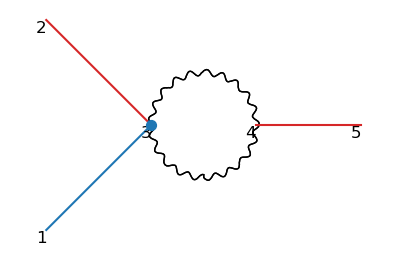

In [444]:
represent_diagram(points, paths, index=True)

### Input/Output particles

Similar to the 1 type case, but with the addition of a new function that return the unique values of the array, needed to identify the input/output particles in `in_out_paths`. A new function `unique_values` has been introduced to simplify the code.

`in_out_paths` returns the points that correspond to input/output particles, in an array that specify the type of particle. The array is of the form (n_types, 2). With the [i, 0] indicating input, and [i, 1] indicating output.

In [ ]:
#From Github copilot
def unique_values(array):
    unique, counts = np.unique(array, return_counts=True)
    unique_values = unique[counts == 1]
    return unique_values

def in_out_paths (paths):
    max_len = max([len(path) for path in paths])
    #len(paths) is the number of type of particles
    in_out_paths = np.zeros((len(paths), 2, max_len), dtype=int)
    unique_vals = unique_values(paths.flatten())
    for i in range(len(paths)):
        inp = 0
        out = 0
        for j in range(max_len):
            if paths[i, j, 0] in unique_vals:
                in_out_paths[i, 1, out] = paths[i, j, 0]
                out += 1
            if paths[i, j, 1] in unique_vals:
                in_out_paths[i, 0, inp] = paths[i, j, 1]
                inp += 1
    in_out_paths = trim_zeros_3D(in_out_paths, axis=2)
    return in_out_paths

### Product of 2 Diagrams (Multiparticle Case)

In the case of multiple types of particles, to connect the different points, there will be some differences compared to the 1 type case. 

Since now the paths are arrays with one more dimension, this need to be taken account. Let's define some diagrams that make connections possible. (We chose some higher order diagrams to be able to find error in the code)

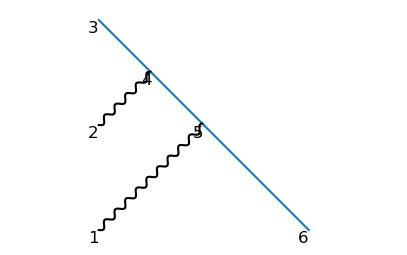

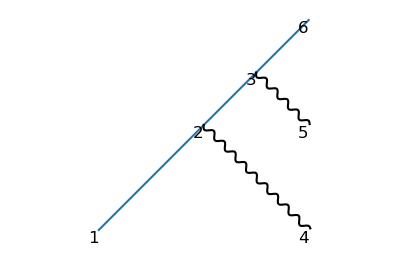

In [446]:
points1 =  np.array([[0, 1], [0, 3], [0, 5], [1, 4], [2, 3],[4, 1]])
paths1_q = np.array([[3, 4], [4, 5], [5, 6]])
paths1_a = np.array([[0, 0]])
paths1_g = np.array([[1, 5], [2, 4]])
paths1 = combine_paths(paths1_q, paths1_a, paths1_g)

points2 =  np.array([[0, 1], [2, 3], [3, 4], [4, 1], [4, 3], [4, 5]])
paths2_q = np.array([[1, 2], [2, 3], [3, 6]])
paths2_a = np.array([[0, 0]])
paths2_g = np.array([[2, 4], [3, 5]])
paths2 = combine_paths(paths2_q, paths2_a, paths2_g)

represent_diagram(points1, paths1, index=True)
represent_diagram(points2, paths2, index=True)



The inputs to the function are, `(points1, paths1, points2, paths2, offset = 0)`. From those we follow the steps,
- Calculate the `in_out_paths` for `paths1`and `paths2`. These are used to determine the number of connections, and how they are connected. In this case the `in_out_paths` are arrays of the form. <br>
    - Index 1: indicate the different types of particles, with `n_types`= `len(in_out_paths1)` = `len(in_out_paths2)`.
    - Index 2: indicate the if the point is a input or output, with `len(in_out_paths1[0])` indicating the max number of input/output particle, one need to remove 0 to get the number of input/output particle.
    - Index 3: indicate the i-th input/output particle.
- Create the new `points` array, concatenating `points1`, with `points2` and considering a displacement on the horizontal axis equal to the max horizontal value of `points1`, and if `offset`different from 0, add that as a vertical displacement.
- Displace the number assign to `in_out_paths2` to match it's new position in `points`

#### Number of new diagrams

Once the framework for the next step is done, we need to consider the different connections, for it we need the following informations, 
- How many new diagrams are produced. For the case of 1 type of particles we reached the following formula, 

\begin{equation}
    s_k = \sum_{i_k=1}^{N_k} n_{i_k}, \,\, \text{with,    } n_{i_k} = \binom{n_{1_k}}{i} \binom{n_{2_k}}{i} i!
\end{equation}

$n_{1_k}$ is the number of input particles from diagram 1 of the particle type $k$, and $n_{2_k}$ is the number of output particles from diagram 2 of the particle type $k$. $N_k$ is the maximum number of connections possible for the particle type $k$

$$
    N_k = min(n_{1_k}, n_{2_k})
$$

but now that there are more particles, we need to consider the cases where only one type of particle is connected, 2 types of particles are connected, and so on, this produces more combinations. 

This situation is equivalent, to from `n_types` boxes, each with $s_k$ elements, taking any number of elements from $1$ to `n_types`, max 1 element per box, how many possible combinations are possible.

\begin{equation}
    S = \sum_{r=1}^{n_\text{types}} \binom{n_\text{types}}{r} \sum_{\substack{I \subseteq \{1, 2, ... n_\text{types}\} \\ |I|= r}} \prod_{k\in I} s_k
\end{equation}

or equivalent to

\begin{equation}
    S = \sum_{\emptyset \neq I \subseteq \{1, 2, ... n_\text{types}\}}  \prod_{k\in I} s_k
\end{equation}

Note: in the code why assign $s_k$ to `n_conenctions` and $S$ to `n_connec`


In [447]:
def how_connected( max_connections, n_connections, n_1, n_2):
    """
    Generate all possible combinations of connections between two diagrams.
    Args:
        max_connections (int): maximum number of connections between the two diagrams for each type of particle
        n_connections (int): number of connections between the two diagrams taking into account the number of types of particles
        n_1 (int): number of input for each type of particle
        n_2 (int): number of output for each type of particle
    Returns:
        combinations (np.array): array of all possible combinations of connections between the two diagrams
        of dimension (n_connections, max_connections, 2)
    """
    combinations = np.zeros((n_connections, max_connections, 2), dtype=int)
    n = 0 
    while n < n_connections:
        for j in range (n_1):
            for k in range(n_2):
                combinations[n, 0] = np.array([j+1, k+1])
                n += 1
                if n == n_connections:
                    break
            if n == n_connections:
                break
            
    n = n_1*n_2
    if max_connections >1:
        while n < n_connections:
            diff = False
            i = 1
            while i < max_connections:  
                for j in range (n_1):
                    for k in range(n_2):
                        for l in range(i):
                            if (j+1) != combinations[n, l, 0] and (k+1) != combinations[n, l, 1]:
                                diff = True
                            else:
                                diff = False
                        if diff:
                            combinations[n, i] = np.array([j+1, k+1])
                            n +=1   
                        if n == n_connections:
                            return combinations      
                i += 1
    else:
        return combinations

def connection (points1, paths1, points2, paths2, offset = 0):
    in_out_paths1 = in_out_paths(paths1)
    in_out_paths2 = in_out_paths(paths2)

    n_types = len(in_out_paths1)

    #Create the new points array
    points = np.zeros((len(points1) + len(points2), 2))
    points[:len(points1)] = points1
    points[len(points1):] = points2 + np.array([np.max(points1)+1, offset])

    #Displace the paths of the second diagram to rename the points
    for i in range(n_types):
        for j in range(len(in_out_paths2[0])):
            for k in range(len(in_out_paths2[0, 0])):
                if in_out_paths2[i, j, k] != 0:
                    in_out_paths2[i, j, k] += len(points1)

    #n1 and n2 indicate the number of input for each type of particle and output for each type of particle
    n1 = np.zeros(n_types, dtype=int)
    n2 = np.zeros(n_types, dtype=int)
    for i in range(n_types):
        n1[i] = len(np.trim_zeros(in_out_paths1[i, 0]))
        n2[i] = len(np.trim_zeros(in_out_paths2[i, 1]))

    #max_connections indicates the maximum number of connections between the two diagrams for each type of particle
    max_connections = np.zeros(n_types, dtype=int)
    for i in range(n_types):
        max_connections[i] = min(n1[i], n2[i])

    #n_connections indicates the number of connections between the two diagrams taking into account the number of types of particles
    n_connections = np.zeros(n_types, dtype=int)
    for j in range(n_types):
        for i in range(int(max_connections[j])):
            n_connections[j] += int(binom(n1[j], i+1)*binom(n2[j], i+1) * factorial(i+1))
    
    #n_connec indicates the total number of connections between the two diagrams
    n_connec = 0
    for subset in range(1, 1 << n_types):
        product = 1
        for i in range(n_types):
            if subset & (1 << i):
                product *= n_connections[i]
        n_connec += product

    #Use a dummy array to store all possible combinations of connections for each type of particle between the two diagrams
    dummy_combinations = np.zeros((sum(n_connections), n_types,  max(max_connections), 2), dtype=int)
    n = 0
    for i in range(n_types):
        dummy_var = how_connected(max_connections[i], n_connections[i], n1[i], n2[i])
        for j in range(n_connections[i]):
            for k in range(max_connections[i]):
                if(dummy_var[j, k, 0] != 0 and dummy_var[j, k, 1] != 0):
                    dummy_combinations[n, i, k] = dummy_var[j, k]
                else:
                    break
            n+=1

    #From the dummy array, create the array combinations that will store all possible combinations of connections between the two diagrams
    #taking into account mixing different types of particles
    combinations = np.zeros((n_connec, n_types, max(max_connections), 2), dtype=int)

    #The first step is to store a copy of the dummy array in the combinations array, without considering the mixing of different 
    #types of particles since there will be diagrams without mixed particles.
    n = 0
    for i in range(n_types):
        if (n_connections[i] == 0):
            continue
        for j in range(np.sum(n_connections[:i]), n_connections[i]+np.sum(n_connections[:i])):
            for k in range(max_connections[i]):
                if(dummy_combinations[j, i, k, 0] != 0 and dummy_combinations[j, i, k, 1] != 0):
                    combinations[n, i, k] = dummy_combinations[j, i, k]
                else:
                    break
            n+=1        

    #The second step is to store the combinations of connections between the two diagrams taking into account the mixing of 
    #different types of particles. The process could be though as filling a tringular matrix with the combinations of connections
    #between the two diagrams. The first row of the matrix corresponds to the one type case, the second row combining 2 elements of 
    #the first row, this means combining 2 types of particles, and so on.

    #The variable n_start indicates the position in the combinations array where the combinations of connections between 
    #the two diagrams taking into account the mixing of different types of particles start.
    n_start = n

    n_prime = 0
    for i in range(n_types-1):
        leng = 0
        for l in range(i+1, n_types):   
            leng += n_connections[i]*n_connections[l]
        for n in range(n_start, leng+n_start):
            combinations[n, i] = dummy_combinations[n_prime, i]
            for j in range(i+1, n_types):
                combinations[n, j] = dummy_combinations[n-n_start+n_connections[i], j]
        n_prime += 1    
    #Create the paths array that will store the connections between the two diagrams.
    paths = np.zeros((n_connec, n_types, len(paths1[0]) + len(paths2[0]) + max(max_connections), 2), dtype=int)
    paths[:n_connec,:n_types,:len(paths1[0])] = paths1
    for i in range(n_connec):
        for j in range(n_types):
            for k in range(max_connections[j]):
                if (combinations[i,j, k, 0] != 0 and combinations[i,j, k, 1] != 0):
                    paths[i,j, len(paths1[0])+k] = np.array([in_out_paths1[j,0, combinations[i, j, k, 0]-1], in_out_paths2[j,1, combinations[i, j, k, 1]-1]])
            if (np.count_nonzero(paths2[j]) != 0):
                for k in range(len(paths2[j])):
                    if (paths2[j, k, 0] != 0 and paths2[j, k, 1] != 0):
                        paths[i,j, len(paths1[0])+max(max_connections)+k] = paths2[j, k] + np.array([len(points1), len(points1)])

    return points, paths


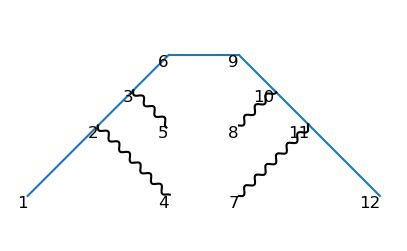

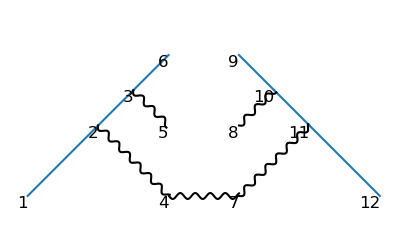

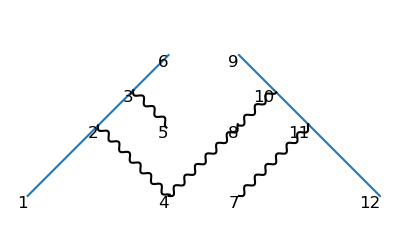

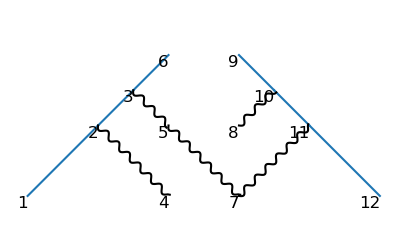

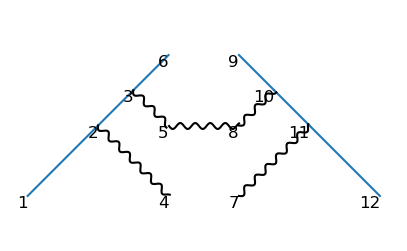

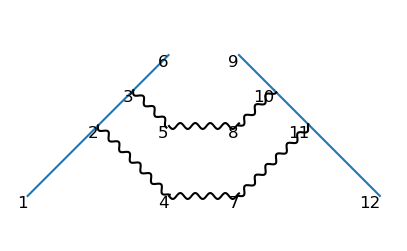

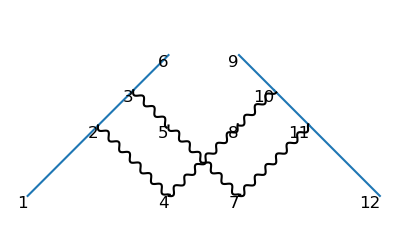

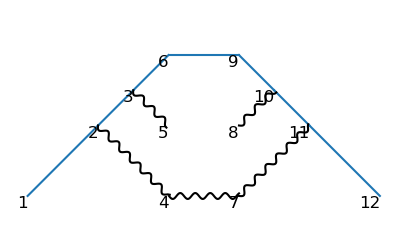

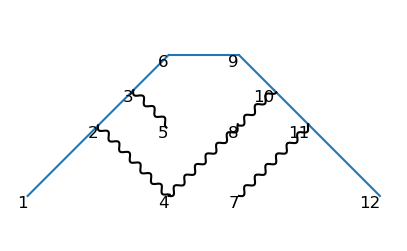

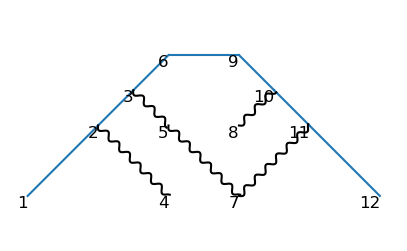

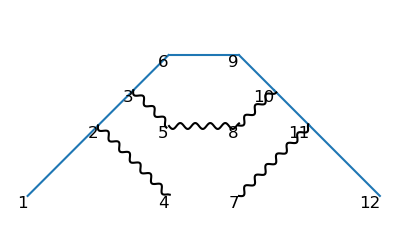

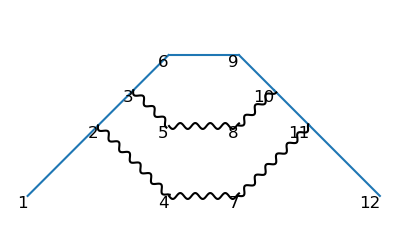

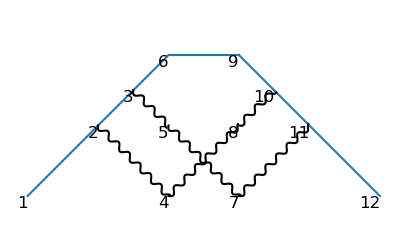

In [448]:
points3, paths3 = connection(points2, paths2, points1, paths1)

for i in range(len(paths3)):
    represent_diagram(points3, paths3[i], index=True)

### Simplify Diagrams

As we have seen the diagrams from above have extra points, we want to simplify the diagrams by removing those unnecesary points. 

In the case of multiple types of particles, we have to be careful and not eliminate any points that used by the other types of particles. So we need to modify the code from the 1 type to take this into account.

In [449]:
def decrement_number_in_array(array, number):
    array[array == number] -= 1
    return array

def decrement_number_in_array_2D(array, number):
    """
    Decrement a number in a 2D array.
    Args:
        array (np.array): 2D array to decrement the number
        number (int): number to decrement
    Returns:
        array (np.array): decremented array
    """
    for i in range(len(array)):
        for j in range(len(array[i])):
            for k in range(2):
                if array[i, j, k] == number:
                    array[i, j, k] -= 1
    return array

def simplify_diagram_it (points, paths):
    """
    Function that will be iterated to simplify the diagram by removing the points and paths that are not needed.
    """
    pos = np.zeros((2, 3), dtype=int)
    for i in range(1, np.max(paths)+1):
        count = 0
        for j in range(len(paths)):
            for k in range(len(paths[j])):
                for l in range(2):
                    if paths[j, k, l] == i:
                        count += 1
                        if count == 1:
                            pos[0] = np.array([j, k, l])
                        elif count == 2:
                            pos[1] = np.array([j, k, l])
                        else:
                            break
        if count == 2 and pos[0, 0] == pos[1, 0]:
            j = pos[0, 0] # type of particle
            points = np.delete(points, i-1, axis=0)
            if pos[0, 2] == 0:
                if pos[1, 2] == 0:
                    prov = np.array([paths[j, pos[0, 1], 1], paths[j, pos[1, 1], 1]])
                elif pos[1, 2] == 1:
                    prov = np.array([paths[j, pos[0, 1], 1], paths[j, pos[1, 1], 0]])  
            elif pos[0, 2] == 1:
                if pos[1, 2] == 0:
                    prov = np.array([paths[j, pos[0, 1], 0], paths[j, pos[1, 1], 1]])                  
                elif pos[1, 1] == 1:
                    prov = np.array([paths[j, pos[0, 1], 0], paths[j, pos[1, 1], 0]])
            paths[j, pos[1, 1]] = np.array([0, 0])
            paths[j, pos[0, 1]] = prov
                    
            for k in range(i, np.max(paths)+1):
                paths = decrement_number_in_array(paths, k)

    return points, trim_zeros_3D(paths, axis=1)

def simplify_diagram (points, paths):
    """
    Simplify the diagram by removing the points and paths that are not needed, by iterating the function simplify_diagram_it, until the 
    number of points and paths does not change anymore.
    """
    new_points, new_paths = simplify_diagram_it(points, paths)
    new_new_points, new_new_paths = simplify_diagram_it(new_points, new_paths)
    while len(new_points) != len(new_new_points) or len(new_paths) != len(new_new_paths):
        new_points, new_paths = new_new_points, new_new_paths
        new_new_points, new_new_paths = simplify_diagram_it(new_points, new_paths)
    return new_new_points, new_new_paths

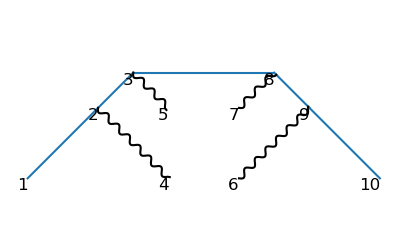

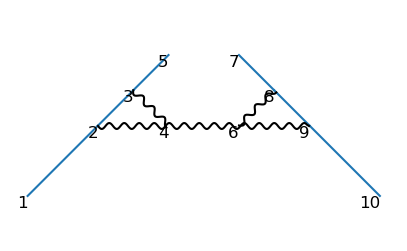

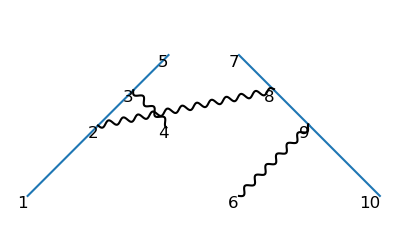

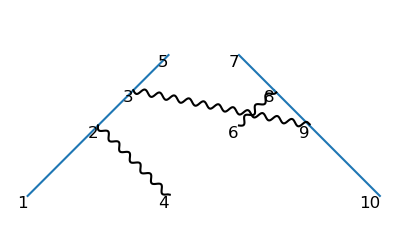

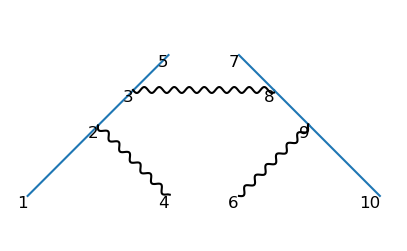

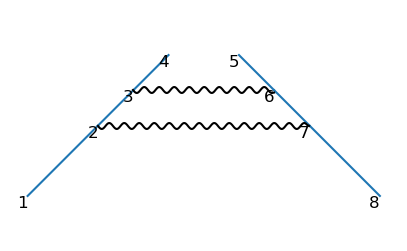

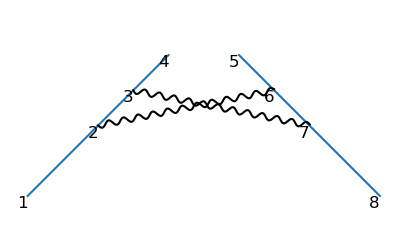

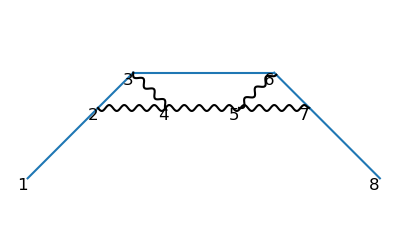

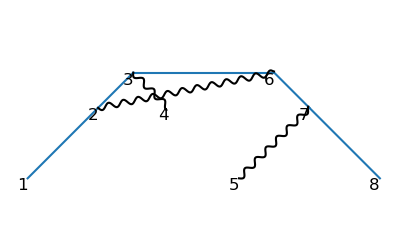

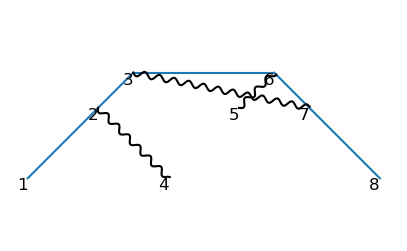

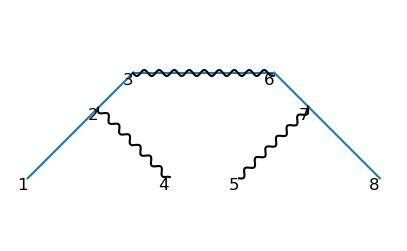

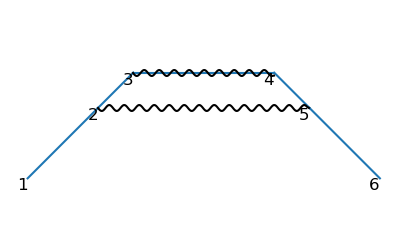

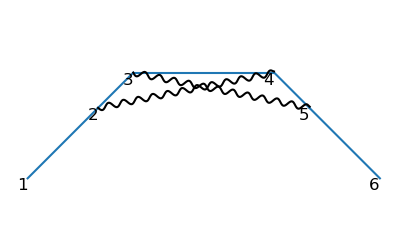

In [450]:
for i in range(len(paths3)):
    new_points3, new_paths3 = simplify_diagram(points3, paths3[i])
    represent_diagram(new_points3, new_paths3, index=True)

### Combine diagrams

#### Hermitic Conjugate

When defining the diagrams, being able to obtain the hermitic conjugate directly can simplify a lot the process. 

In [451]:
def herm_conj (points, paths):
    """
    Return the hermitian conjugate of the diagram by changing x position of the points
    """
    max = np.max(points)
    for i in range(len(points)):
        points[i, 0] = max - points[i, 0]-1
    return points, paths

#### Canonical Diagrams

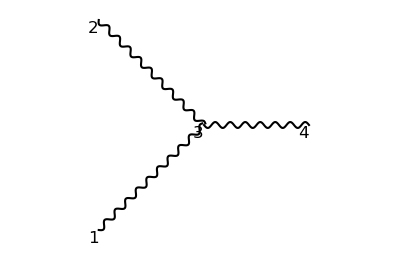

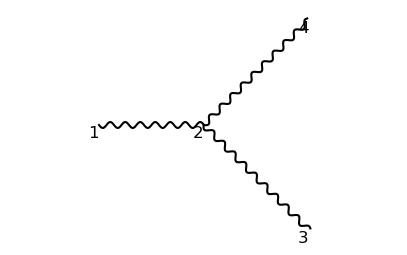

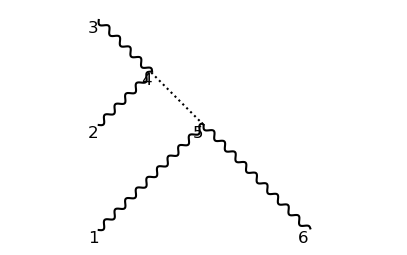

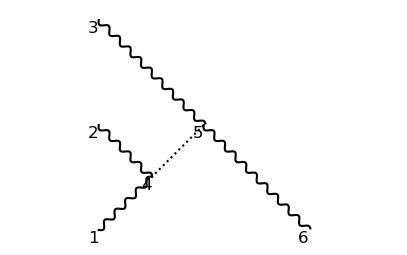

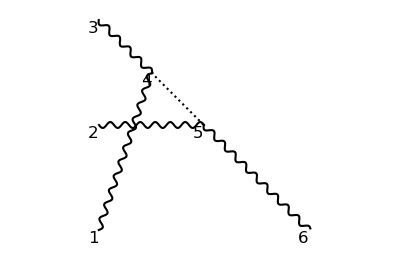

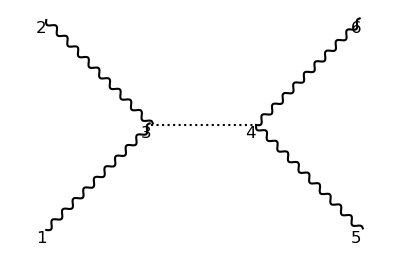

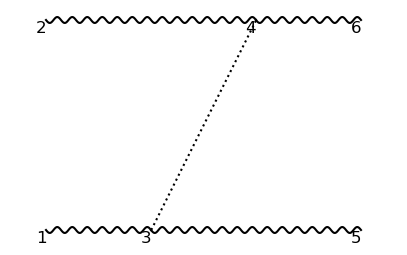

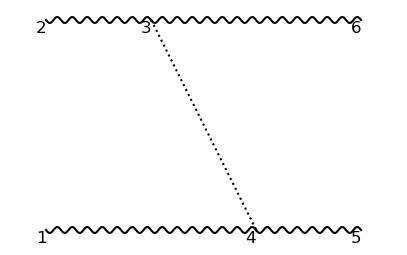

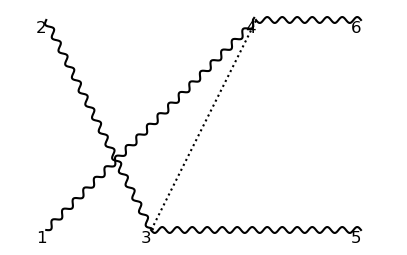

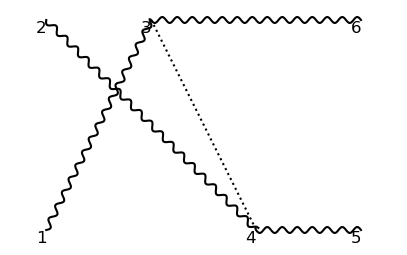

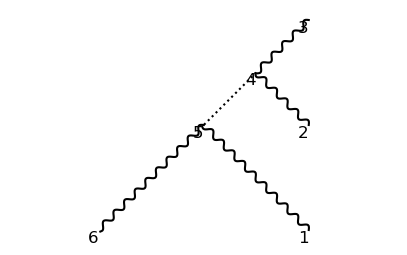

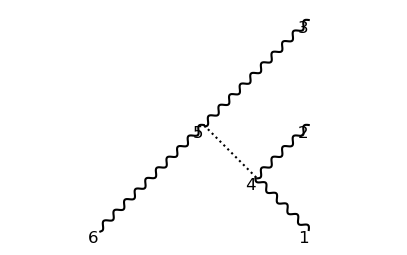

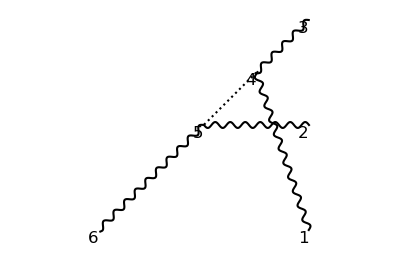

In [452]:
points_1st_1 = np.array([[0, 1], [0, 3], [1, 2], [2, 2]])
paths_1st_1g = np.array([[1, 3], [2, 3], [3, 4]]) 
paths_1st_1i = np.array([[0, 0]])

points_1st_2 = np.array([[0, 2], [1, 2], [2, 1], [2, 3]])
paths_1st_2g = np.array([[1, 2], [2, 3], [2, 4]]) 
paths_1st_2i = np.array([[0, 0]])

paths_1st_1 = combine_paths(paths_1st_1g, paths_1st_1i)
paths_1st_2 = combine_paths(paths_1st_2g, paths_1st_2i)

can_points_1st = np.empty((2, max(len(points_1st_1), len(points_1st_2)), 2))
can_points_1st[0] = points_1st_1
can_points_1st[1] = points_1st_2

can_paths_1st = np.empty((2, max(len(paths_1st_1), len(paths_1st_2)), max(len(paths_1st_1[0]), len(paths_1st_2[0])), 2), dtype=int)
can_paths_1st[0] = paths_1st_1
can_paths_1st[1] = paths_1st_2

for i in range(len(can_paths_1st)):
    represent_diagram(can_points_1st[i], can_paths_1st[i], index=True, line=["photon", "dotted"], colors=["black", "black"])

points_2nd_1_1 = np.array([[0, 1], [0, 3], [0, 5], [1, 4], [2, 3], [4, 1]])
paths_2nd_1_1g = np.array([[1, 5], [2, 4], [3, 4], [5, 6]])
paths_2nd_1_1i = np.array([[4, 5]])
paths_2nd_1_1 = combine_paths(paths_2nd_1_1g, paths_2nd_1_1i)

points_2nd_1_2 = np.array([[0, 1], [0, 3], [0, 5], [1, 2], [2, 3], [4, 1]])
paths_2nd_1_2g = np.array([[1, 4], [2, 4], [3, 5], [5, 6]])
paths_2nd_1_2i = np.array([[4, 5]])
paths_2nd_1_2 = combine_paths(paths_2nd_1_2g, paths_2nd_1_2i)

points_2nd_1_3 = np.array([[0, 1], [0, 3], [0, 5], [1, 4], [2, 3], [4, 1]])
paths_2nd_1_3g = np.array([[1, 4], [2, 5], [3, 4], [5, 6]])
paths_2nd_1_3i = np.array([[4, 5]])
paths_2nd_1_3 = combine_paths(paths_2nd_1_3g, paths_2nd_1_3i)

points_2nd_2_1 = np.array([[0, 1], [0, 3], [1, 2], [2, 2], [3, 1], [3, 3]])
paths_2nd_2_1g = np.array([[1, 3], [2, 3], [4, 5], [4, 6]])
paths_2nd_2_1i = np.array([[3, 4]])
paths_2nd_2_1 = combine_paths(paths_2nd_2_1g, paths_2nd_2_1i)

points_2nd_2_2 = np.array([[0, 1], [0, 3], [1, 1], [2, 3], [3, 1], [3, 3]])
paths_2nd_2_2g = np.array([[1, 3], [2, 4], [3, 5], [4, 6]])
paths_2nd_2_2i = np.array([[3, 4]])
paths_2nd_2_2 = combine_paths(paths_2nd_2_2g, paths_2nd_2_2i)

points_2nd_2_3 = np.array([[0, 1], [0, 3], [1, 3], [2, 1], [3, 1], [3, 3]])
paths_2nd_2_3g = np.array([[1, 4], [2, 3], [3, 6], [4, 5]])
paths_2nd_2_3i = np.array([[3, 4]])
paths_2nd_2_3 = combine_paths(paths_2nd_2_3g, paths_2nd_2_3i)

points_2nd_2_4 = np.array([[0, 1], [0, 3], [1, 1], [2, 3], [3, 1], [3, 3]])
paths_2nd_2_4g = np.array([[1, 4], [2, 3], [3, 5], [4, 6]])
paths_2nd_2_4i = np.array([[3, 4]])
paths_2nd_2_4 = combine_paths(paths_2nd_2_4g, paths_2nd_2_4i)

points_2nd_2_5 = np.array([[0, 1], [0, 3], [1, 3], [2, 1], [3, 1], [3, 3]])
paths_2nd_2_5g = np.array([[1, 3], [2, 4], [3, 6], [4, 5]])
paths_2nd_2_5i = np.array([[3, 4]])
paths_2nd_2_5 = combine_paths(paths_2nd_2_5g, paths_2nd_2_5i)

can_points_2nd = np.empty((11, max(len(points_2nd_1_1), len(points_2nd_1_2), len(points_2nd_1_3)), 2))
can_points_2nd[0] = points_2nd_1_1
can_points_2nd[1] = points_2nd_1_2
can_points_2nd[2] = points_2nd_1_3
can_points_2nd[3] = points_2nd_2_1
can_points_2nd[4] = points_2nd_2_2
can_points_2nd[5] = points_2nd_2_3
can_points_2nd[6] = points_2nd_2_4
can_points_2nd[7] = points_2nd_2_5
can_points_2nd[8] = herm_conj(points_2nd_1_1, paths_2nd_1_1)[0]
can_points_2nd[9] = herm_conj(points_2nd_1_2, paths_2nd_1_2)[0]
can_points_2nd[10] = herm_conj(points_2nd_1_3, paths_2nd_1_3)[0]

can_paths_2nd = np.empty((11, max(len(paths_2nd_1_1), len(paths_2nd_1_2), len(paths_2nd_1_3)), max(len(paths_2nd_1_1[0]), len(paths_2nd_1_2[0]), len(paths_2nd_1_3[0])), 2), dtype=int)
can_paths_2nd[0] = paths_2nd_1_1
can_paths_2nd[1] = paths_2nd_1_2
can_paths_2nd[2] = paths_2nd_1_3
can_paths_2nd[3] = paths_2nd_2_1
can_paths_2nd[4] = paths_2nd_2_2
can_paths_2nd[5] = paths_2nd_2_3
can_paths_2nd[6] = paths_2nd_2_4
can_paths_2nd[7] = paths_2nd_2_5
can_paths_2nd[8] = herm_conj(points_2nd_1_1, paths_2nd_1_1)[1]
can_paths_2nd[9] = herm_conj(points_2nd_1_2, paths_2nd_1_2)[1]
can_paths_2nd[10] = herm_conj(points_2nd_1_3, paths_2nd_1_3)[1]

for i in range(len(can_paths_2nd)):
    represent_diagram(can_points_2nd[i], can_paths_2nd[i], index=True, line=["photon", "dotted"], colors=["black", "black"])

can_points = [can_points_1st, can_points_2nd]
can_paths = [can_paths_1st, can_paths_2nd]

#### Combine diagrams function

The number of diagrams produced can vary a lot depending on the diagrams involved, and the calc to obtain this number can be difficult. Let's consider it step by step

Another thing we have to take into account is that when there is a loop, we need to add a counterterm diagram to "correct" the divergence produced. 

In [453]:
def combine_diagrams_order (points, paths, number, offset = 0):
    curr_max_order = len(points)
    n_types = len(paths[0][0])
    max_points = np.zeros((n_types, 2), dtype=int)

    n1 = np.zeros(n_types, dtype=int)
    n2 = np.zeros(n_types, dtype=int)
    for i in range(len(paths[0])): #in number of first order diagrams
        for j in range(n_types):
            n1[j] = len(np.trim_zeros(in_out_paths(paths[0][i])[j, 0]))
            if (n1[j] > max_points[j, 0]):
                max_points[j, 0] = n1[j]
            n2[j] = len(np.trim_zeros(in_out_paths(paths[0][i])[j, 1]))
            if (n2[j] > max_points[j, 1]):
                max_points[j, 1] = n2[j]
    for i in range(len(paths[-1])):
        for j in range(n_types):
            n1[j] = len(np.trim_zeros(in_out_paths(paths[-1][i])[j, 0]))
            if (n1[j] > max_points[j, 0]):
                max_points[j, 0] = n1[j]
            n2[j] = len(np.trim_zeros(in_out_paths(paths[-1][i])[j, 1]))
            if (n2[j] > max_points[j, 1]):
                max_points[j, 1] = n2[j]

    max_connections = np.zeros(n_types, dtype=int)
    for i in range(n_types):
        max_connections[i] = min(max_points[i, 0], max_points[i, 1])

    n_connec = 0
    n_connections = np.zeros(n_types, dtype=int)
    for i in range(len(paths[0])):
        for j in range(n_types):
            for k in range(int(max_connections[j])):
                n_connections[j] += int(binom(n1[j], i+1)*binom(n2[j], k+1) * factorial(k+1))
        #n_connec indicates the total number of connections between the two diagrams
        for subset in range(1, 1 << n_types):
            product = 1
            for i in range(n_types):
                if subset & (1 << k):
                    product *= n_connections[k]
            n_connec += product

    n = 0
    d = 200
    f = 20
    if len(points) == 1:
        new_points = np.zeros((n_types*n_connec+d, len(points[0][0]) + len(points[-1][0]), 2))
        new_paths = np.zeros((n_types*n_connec+d, n_types, len(paths[0][0]) + len(paths[-1][0])+np.max(max_connections)+f , 2), dtype=int)
        new_number = np.zeros((n_types*n_connec+d, 1), dtype=int)
        for i in range(len(paths[0])):
            for j in range(len(paths[-1])):
                dummy_points, dummy_paths = connection(trim_zeros_2D(points[0][i]), trim_zeros_3D(paths[0][i], axis=1), trim_zeros_2D(points[-1][j]), trim_zeros_3D(paths[-1][j], axis = 1), offset=offset)
                for k in range(len(dummy_paths)):
                    simp_points, simp_paths = simplify_diagram(dummy_points, trim_zeros_3D(dummy_paths[k], axis=1))
                    for l in range(len(simp_points)):
                        new_points[n, l] = simp_points[l]
                    for l in range(n_types):
                        for m in range(len(simp_paths[0])):
                            new_paths[n, l, m] = simp_paths[l, m]
                    new_number[n] = number[0][i] * number[-1][j]
                    n += 1
    else:
        new_points = np.zeros((n_types*len(paths[0])*len(paths[-1])*n_connec+d, len(points[0][0]) + len(points[-1][0]), 2))
        new_paths = np.zeros((n_types*len(paths[0])*len(paths[-1])*n_connec+d, n_types, len(paths[0][0]) + len(paths[-1][0])+np.max(max_connections)+d, 2), dtype=int)
        new_number = np.zeros((n_types*len(paths[0])*len(paths[-1])*n_connec+d, 1), dtype=int)
        for i in range(len(paths[0])):
            for j in range(len(paths[-1])):
                dummy_points, dummy_paths = connection(trim_zeros_2D(points[0][i]), trim_zeros_3D(paths[0][i], axis=1), trim_zeros_2D(points[-1][j]), trim_zeros_3D(paths[-1][j], axis = 1), offset=offset)
                for k in range(len(dummy_paths)):
                    simp_points, simp_paths = simplify_diagram(dummy_points, trim_zeros_3D(dummy_paths[k], axis=1))
                    for l in range(len(simp_points)):
                        new_points[n, l] = simp_points[l]
                    for l in range(n_types):
                        for m in range(len(simp_paths[0])):
                            new_paths[n, l, m] = simp_paths[l, m]
                    new_number[n] = number[0][i] * number[-1][j]
                    n += 1
        for i in range(1, curr_max_order):
            for j in range(i-1, len(paths)):
                if (i+1 + j) == curr_max_order:
                    for k in range(len(can_paths[i])):
                        for l in range(len(paths[j])):
                            dummy_points, dummy_paths = connection(trim_zeros_2D(can_points[i][k]), trim_zeros_3D(can_paths[i][k], axis=1), trim_zeros_2D(points[j][l]), trim_zeros_3D(paths[j][l], axis = 1), offset=offset)
                            for m in range(len(dummy_paths)):
                                simp_points, simp_paths = simplify_diagram(dummy_points, trim_zeros_3D(dummy_paths[m], axis=1))
                                for o in range(len(simp_points)):
                                    new_points[n, o] = simp_points[o]
                                for o in range(n_types):
                                    for p in range(len(simp_paths[0])):
                                        new_paths[n, o, p] = simp_paths[o, p]
                                new_number[n] = number[i][k] * number[j][l]        
                                n += 1
                    for k in range(len(can_paths[i])):
                        for l in range(len(paths[j])):
                            dummy_points, dummy_paths = connection(trim_zeros_2D(points[j][l]), trim_zeros_3D(paths[j][l], axis=1), trim_zeros_2D(can_points[i][k]), trim_zeros_3D(can_paths[i][k], axis = 1), offset=offset)
                            for m in range(len(dummy_paths)):
                                simp_points, simp_paths = simplify_diagram(dummy_points, trim_zeros_3D(dummy_paths[m], axis=1))
                                for o in range(len(simp_points)):
                                    new_points[n, o] = simp_points[o]
                                for o in range(n_types):
                                    for p in range(len(simp_paths[0])):
                                        new_paths[n, o, p] = simp_paths[o, p]
                                new_number[n] = number[i][k] * number[j][l] 
                                n += 1
    return new_points, new_paths, new_number

In [454]:
number_1st = np.array([[1],[1], [1], [1]])
points_2nd, paths_2nd, numbers_2nd = combine_diagrams_order([can_points_1st], [can_paths_1st], [number_1st], offset=0)
points_3rd, paths_3rd, numbers_3rd = combine_diagrams_order([can_points_1st, points_2nd], [can_paths_1st, paths_2nd], [number_1st, numbers_2nd],  offset=0)

### Group diagrams

After the calculations there are many similar diagrams, we are interested in grouping all the similar diagrams and just indicating the number of repetitions, their symmetry factor. For this purpose we can focus just in the structure of the path arrays.

In [455]:
def all_components_in_other(array1, array2):
    for row1 in array1:
        found = False
        for row2 in array2:
            if np.array_equal(np.sort(row1), np.sort(row2)):
                found = True
                break
        if not found:
            return False
    return True

def group_diagrams (points, paths, number):
    group_paths = np.zeros((1, len(paths[0]), len(paths[0, 0]), 2), dtype=int)
    group_points = np.zeros((1, len(points[0]), 2))
    group_paths[0] = paths[0]
    group_points[0] = points[0]
    count = np.zeros((1), dtype=int)
    count[0] = number[0][0]
    for i in range(1, len(paths)):
        if (paths[i] == 0).all():
            continue
        cont = False
        cont_2 = True
        for j in range(len(group_paths)):
            for k in range(len(paths[0])):
                if all_components_in_other(paths[i, k], group_paths[j, k]):
                    cont_2 = True
                else:
                    cont_2 = False
                    break
            if cont_2:
                cont = False
                count[j] += number[i][0]
                break
            else:
                cont = True
        if cont: 
            group_paths = np.append(group_paths, [paths[i]], axis=0)
            group_points = np.append(group_points, [points[i]], axis=0)
            count = np.append(count, [number[i][0]], axis=0)
    return group_points, group_paths, count
    

### Correct the diagrams

The diagrams that we have obtained now may be difficult to intepret in some cases, this is mostly due to 2 problems

- Input/Output particle not clear, the position for the input/output particles may remain in the middle of the diagrams instead of the edges, were we are used.
- Path overlaping, due to the construction there may be times that 2 or more paths coincide, making it difficult/impossible to decifer them.

Another detail that would be appreciated is making the arms of a diagrams not suddenly change direction. But not a priority right now.

The problem for this transformation is that depending on the type of diagram (by this I mean how many ins and outs a diagram has) the structure of the diagram could change drastically As an example for diagrams of 2 to 2, we are used to represent the ins and outs parallel to each other, and for 1 to 2, or 1 to 3 diagrams we are used to represent the outs (in this case) at a 90º angle. 

In [456]:
def reposition_diagram (points, in_out_path):
    minx_point = np.min(points[:, 0])
    maxx_point = np.max(points[:, 0])

    for i in range(len(in_out_path)):
        for j in in_out_path[i, 0]:
            points[j-1, 0] = maxx_point
        for j in in_out_path[i, 1]:
            points[j-1, 0] = minx_point
    return points

def detect_3p_loops(points, paths):
    loop = np.zeros((len(paths), int(len(trim_zeros_2D(paths[0]))/3), 3), dtype=int)
    n = 0
    for i in range(len(paths)):
        if np.count_nonzero(paths[i]) == 0:
            continue
        path = trim_zeros_2D(paths[i])
        if (len(path) < 3):
            continue
        index = np.arange(len(path))
        j = 0
        for j in range(len(path)):
            if j in index:
                start = path[j, 0]
                end = path[j, 1]
                next = -1
                for k in range(len(path)):
                    if(k != j and k in index):
                        if path[k, 0] == start:
                            next = path[k, 1]
                        elif path[k, 1] == start:
                            next = path[k, 0]
                        if next == -1:
                            continue
                        for l in range(len(path)):
                            next2 = -1
                            if (l != j and l!= k and l in index):
                                if path[l, 0] == next:
                                    next2 = path[l, 1]
                                elif path[l, 1] == next:
                                    next2 = path[l, 0]
                                if next2 == next:
                                    continue
                                if next2 == end:
                                    loop[i, n, 0] = j+1
                                    loop[i, n, 1] = k+1
                                    loop[i, n, 2] = l+1
                                    index = np.delete(index, np.where(index == j))
                                    index = np.delete(index, np.where(index == k))
                                    index = np.delete(index, np.where(index == l))

    return trim_zeros_3D(loop, axis=0)

def detect_superposition(points, paths):
    loop = detect_3p_loops(points, paths)
    if np.count_nonzero(loop) == 0:
        return points, paths  
    else:
        for i in range(len(loop)):
            if np.count_nonzero(loop[i]) == 0:
                continue
            for j in range(len(loop[i])):
                if np.count_nonzero(loop[i, j]) == 0:
                    continue
                else:
                    height = points[paths[i,loop[i, j, 0]-1, 0]-1, 1]
                    sorted_array = sorted([paths[i,loop[i, j, 0]-1, 0], paths[i,loop[i, j, 1]-1, 0], paths[i,loop[i, j, 2]-1, 0], paths[i,loop[i, j, 0]-1, 1], paths[i,loop[i, j, 1]-1, 1], paths[i,loop[i, j, 2]-1, 1]])
                    same_height = True
                    for k in sorted_array:
                        if points[k-1, 1] != height:
                            same_height = False
                            break
                    if same_height:
                        middle = sorted_array[2]-1
                        points[middle, 1] = height+1
                    else:
                        continue
        return points, paths

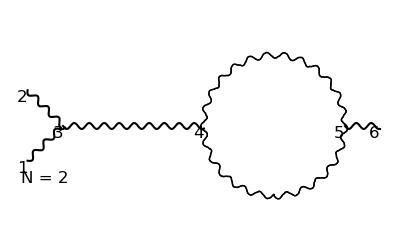

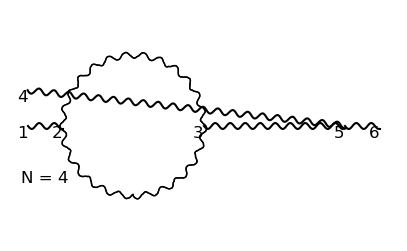

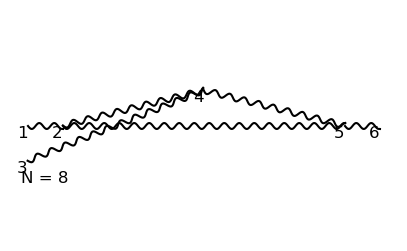

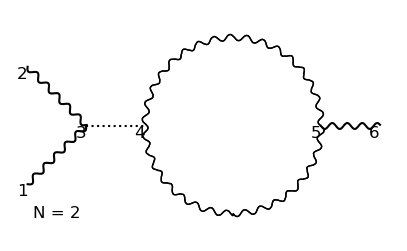

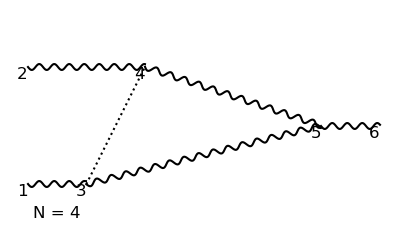

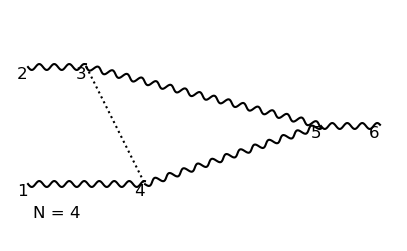

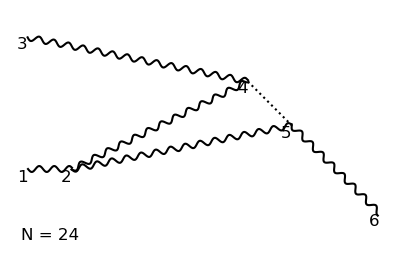

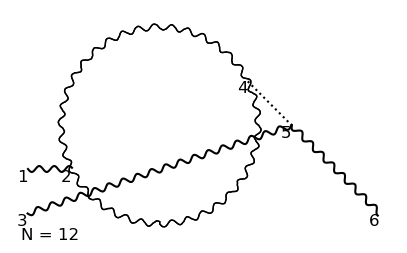

In [457]:

points3, paths3, count3 = group_diagrams(points_3rd, paths_3rd, numbers_3rd)

for i in range(len(paths3)):
    in_out_paths_3 = in_out_paths(paths3[i])
    inp = 0
    out = 0
    for j in range(len(paths3[0])):
        inp += len(np.trim_zeros(in_out_paths_3[j, 0]))
        out += len(np.trim_zeros(in_out_paths_3[j, 1]))
    if inp == 1 and out == 2:
        points3[i], paths3[i] = detect_superposition(points3[i], paths3[i])
        represent_diagram(reposition_diagram(points3[i], in_out_paths_3), paths3[i], index=True, line=["photon", "dotted"], colors=["black", "black"], number=count3[i])